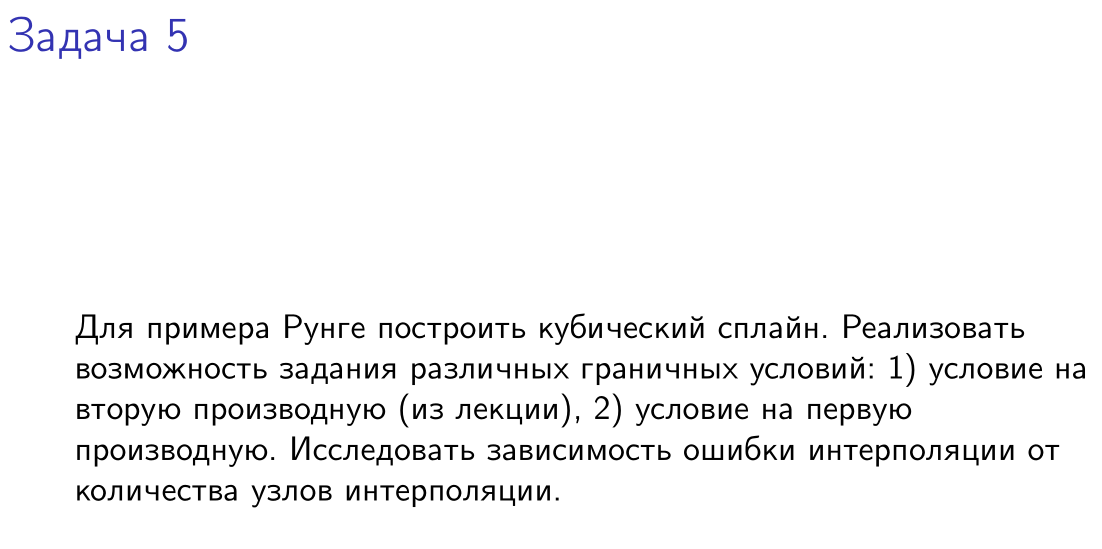

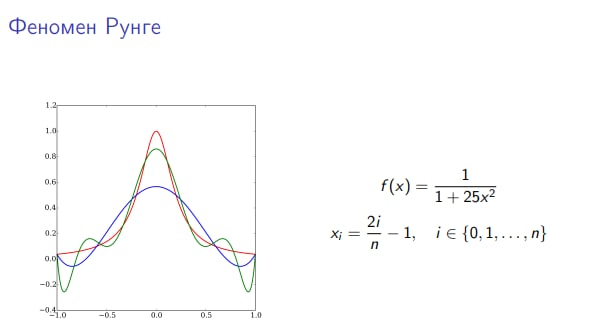

In [10]:
import numpy as np
import plotly.graph_objects as go
from scipy.linalg import solve_banded, solve
import plotly.express as px
from functools import partial
from tqdm import tqdm_notebook
import numba
import warnings


In [11]:
def f(x):
    return 1 / (1+25*x**2)

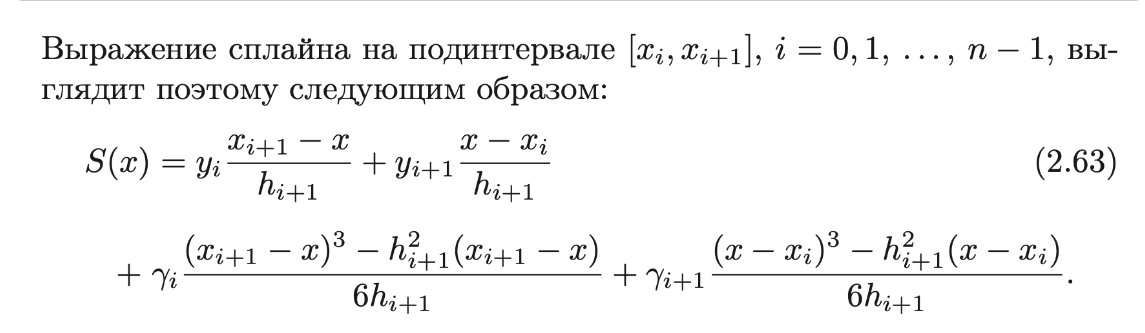

In [12]:
def S(x,X, i, n, y,h,a): 
    if(0 <= i < n):
        return y[i] * (x[i + 1] - X) / h + y[i+1] * (X - x[i]) / h + a[i] * ((x[i + 1] - X) ** 3 - h ** 2 * (x[i + 1] - X)) / (6 * h) + a[i + 1] * ((X - x[i]) ** 3 - h ** 2 * (X - x[i])) / (6 * h)
def s(x,X,n,y,h,a):
    indexs = np.searchsorted(x, X, side='right')
    return np.array([S(x,X[i], indexs[i] - 1, n, y,h,a) for i in range(X.shape[0])])

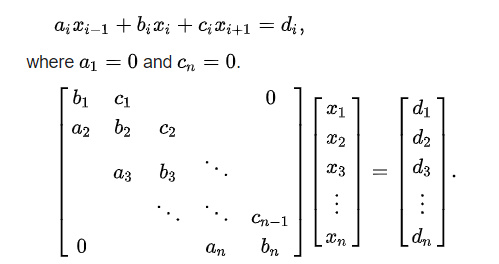

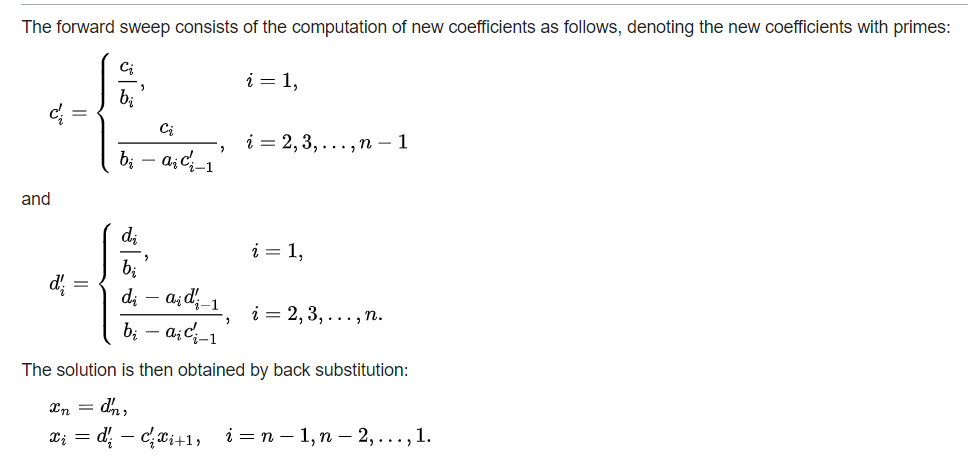

In [13]:
def progon(a,b,c,d):
    n = len(d)  
    m1 = np.zeros(n-1,float)
    m2 = np.zeros(n, float)
    res = np.zeros(n,float)
    m1[0] = c[0]/b[0]
    m2[0] = d[0]/b[0]
    for i in range(1,n-1):
        m1[i] = c[i]/(b[i] - a[i-1]*m1[i-1])
    for i in range(1,n):
        m2[i] = (d[i] - a[i-1]*m2[i-1])/(b[i] - a[i-1]*m1[i-1])
    res[n-1] = m2[n-1]
    for i in range(n-1,0,-1):
        res[i-1] = m2[i-1] - m1[i-1]*res[i]
    return res

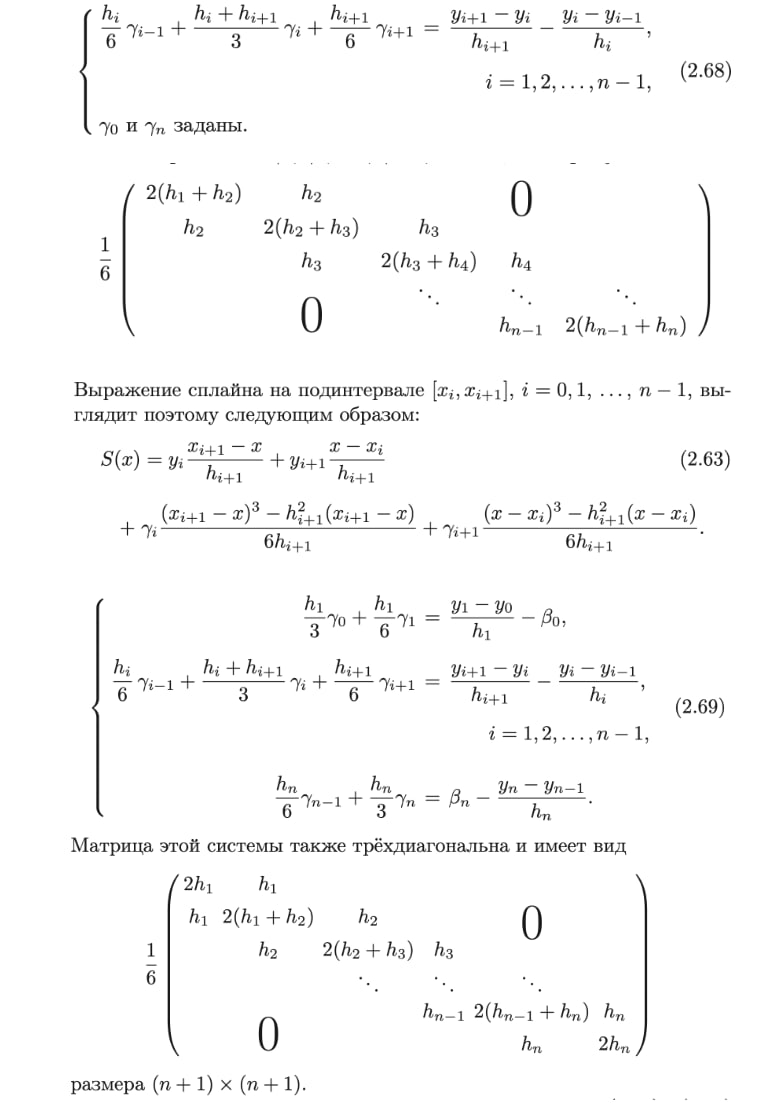

In [96]:
def first(f,a,b,n,par_0,par_n):
    x = np.linspace(a, b, n + 1)
    y = f(x)
    h = (b - a) / n
    m1 = 1/6 * np.array([2*h] + [4*h] * (n - 1) + [2*h])
    m2 = 1/6 * np.array([h] * (n))
    m3 = 1/6 * np.array([h] * (n)) 
    b_1 = np.array([(y[1] - y[0]) / h - par_0] + [(y[i + 1] - y[i])/h - (y[i] - y[i-1])/h for i in range(1, n)] + [par_n - (y[n] - y[n - 1]) / h]) 
    gam = progon(m3,m1,m2,b_1) 
    fig = go.Figure()
    fig.add_trace(go.Line(x=list(np.linspace(a, b, n * 10)[:-1])+[b], y=list(s(x,np.linspace(a, b, n * 10)[:-1],n,y,h,gam))))
    fig.add_trace(go.Line(x=list(np.linspace(a, b, n * 10)[:-1])+[b], y=list(f(np.linspace(a, b, n * 10)[:-1]))))
    fig.show()

In [100]:
first(f,-1,1,10,1,1)

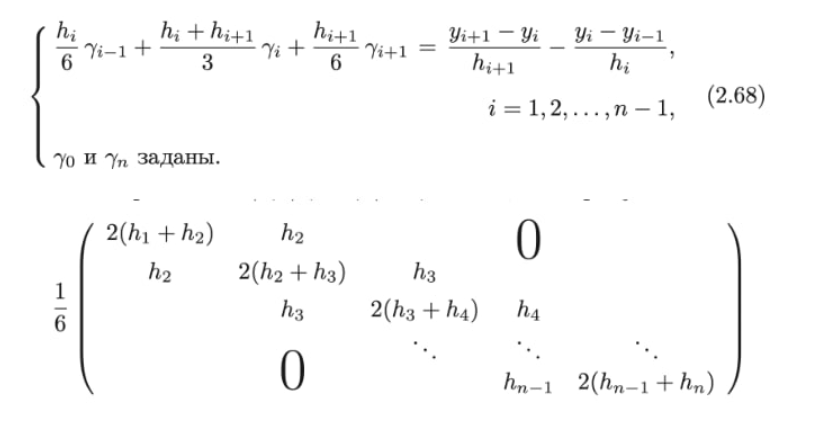

In [98]:
def second(f,a,b,n,par_0,par_n):
    x = np.linspace(a, b, n + 1)
    y = f(x)
    h = (b - a) / n
    m1 = 1/6 * np.array([4*h] * (n - 1))
    m2 = 1/6 * np.array([h] * (n - 2))
    m3 = 1/6 * np.array([h] * (n - 2))
    b_1 = np.array([(y[i + 1] - y[i])/h - (y[i] - y[i-1])/h for i in range(1, n)]) #2.68 
    b_1[0] += -par_0 * h/6
    b_1[n-2] += -par_n * h/6
    gam = progon(m3,m1,m2,b_1) 
    gam = np.concatenate([[par_0],gam,[par_n]]) 
    fig = go.Figure()
    fig.add_trace(go.Line(x=list(np.linspace(a, b, n * 10)[:-1])+[b], y=list(s(x,np.linspace(a, b, n * 10)[:-1],n,y,h,gam))))
    fig.add_trace(go.Line(x=list(np.linspace(a, b, n * 10)[:-1])+[b], y=list(f(np.linspace(a, b, n * 10)[:-1]))))
    fig.show()

In [99]:
second(f,-1,1,11,10,10)

In [18]:
def interp_1(a, b, n, par_0, par_n):
    x = np.linspace(a, b, n + 1)
    y = f(x)
    h = (b - a) / n
    error = np.zeros(n)
    
    m1 = 1/6 * np.array([2*h] + [4*h] * (n - 1) + [2*h])
    m2 = 1/6 * np.array([h] * (n))
    m3 = 1/6 * np.array([h] * (n))
    b_1 = np.array([(y[1] - y[0]) / h - par_0] + [(y[i + 1] - y[i])/h - (y[i] - y[i-1])/h for i in range(1, n)] + [par_n - (y[n] - y[n - 1]) / h])
    gam = progon(m3,m1,m2,b_1)
        
    for i in range(n):
        X = np.linspace(x[i], x[i + 1], n)[:-1]
        yt = S(x,X, i, n, y,h,gam)
        error[i] = max(abs(yt - f(X)))
    return max(error)

def interp_2(a, b, n, par_0, par_n):
    x = np.linspace(a, b, n + 1)
    y = f(x)
    h = (b - a) / n
    error = np.zeros(n)
    
    m1 = 1/6 * np.array([4*h] * (n - 1))
    m2 = 1/6 * np.array([h] * (n - 2))
    m3 = 1/6 * np.array([h] * (n - 2))
    b_1 = np.array([(y[i + 1] - y[i])/h - (y[i] - y[i-1])/h for i in range(1, n)])
    b_1[0] += -par_0 * h/6
    b_1[n-2] += -par_n * h/6
    gam = progon(m3,m1,m2,b_1)
    gam = np.concatenate([[par_0],gam,[par_n]])
        
    for i in range(n):
        X = np.linspace(x[i], x[i + 1], n)[:-1]
        yt = S(x,X, i, n, y,h,gam)
        error[i] = max(abs(yt - f(X)))
    return max(error)

In [59]:
ns=np.array([i for i in range(3, 100)])
int1 = [interp_1(a=-1, b=1,n=ns[i],par_0=10, par_n=10) for i in range(ns.shape[0])] 
int2 = [interp_2(a=-1, b=1,n=ns[i],par_0=10, par_n=10) for i in range(ns.shape[0])]
print("ns = ", )

In [60]:
px.line(x=ns, y=np.log2([e for e in int1]))

In [61]:
px.line(x=ns, y=np.log([e for e in int2]))